# Index

1. [Imports](#Imports)
2. [Dataset Importation](#Dataset-Importation)
3. [Data Exploration](#Data-Exploration)
4. [Data Cleaning](#Data-Cleaning)
5. [Sampling patients to reduce data size](#Sampling-patients-to-reduce-data-size)
   - [Checking distribution from original to sampled](#Checking-distribution-from-original-to-sampled)
   - [Final Patients](#Final-Patients)
6. [Preprocessing (patient data)](#Preprocessing-(patient-data))
   - [Demographic Data](#Demographic-Data)

## Imports

In [113]:
# ======================
# OS AND FILE MANAGEMENT
# ======================
import shutil
import random
from glob import glob
import pickle
import re
import xml.etree.ElementTree as ET

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Add to sys.path if not present
if project_root not in sys.path:
    sys.path.insert(0, project_root)


# ================================
# SCIENTIFIC COMPUTING + DATA I/O
# ================================
import numpy as np
import pandas as pd

# ==================
# IMAGE PROCESSING
# ==================
import cv2
import pydicom

# Image Augmentation (Albumentations)
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, Affine,
    GaussianBlur, CLAHE, RandomGamma, GaussNoise
)

# ================
# VISUALIZATION
# ================
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ===========================
# MACHINE LEARNING UTILITIES
# ===========================
from sklearn.model_selection import train_test_split
from collections import defaultdict

# ===========================
# CUSTOM PROJECT IMPORTS
# (new structure under src/)
# ===========================

# --- Preprocessing ---
from src.preprocessing.uid_mapping import getUID_path
from src.preprocessing.dicom_io import read_dicom_image
from src.preprocessing.xml_parsing import extract_bounding_boxes
from src.preprocessing.dataset_building import (
    create_dataset,
    get_images_by_patient_id
)
from src.preprocessing.yolo_conversion import preprocess_images

# Balanced sampling utilities
from src.preprocessing.sampling import (
    relaxed_stratified_sample,
    add_more_patients,
    get_target_sample,
    adjust_sample_size,
    calculate_stage_distribution,
    compare_distributions,
    check_balance
)

# --- Augmentation ---
from src.augmentation.augmentation_yolo import (
    augment_yolo_images_train,
    augment_yolo_images_val
)

# --- Splitting ---
from src.splitting.dataset_splitting import split_data

# --- Statistics ---
from src.statistics.patient_label_statistics import (
    count_labels_by_class,
    count_labels_by_class_and_source,
    count_images_labels_patients_by_class
)

# --- Visualization ---
from src.visualization.plot_bboxes import (
    visualize_image_with_bboxes,
    visualize_image_with_bboxes_legend
)
from src.visualization.patient_visualization import visualize_image_by_uid
from src.visualization.yolo_visualization import visualize_yolo_images

# --- Utility Tools ---
from src.utils.file_utils import (
    load_dataset,
    loadFileInformation
)
    
from src.utils.extract_number import extract_number
from src.utils.subject_utils import (
    count_unique_subject_ids,
    patient_count_by_group,
    count_labels_by_class_and_source,
    count_labels_by_class,
    count_images_labels_patients_by_class
)   

### Dataset Importation

In [2]:
df = pd.read_excel('../../data/statistics_clinical.xlsx')

## Data Exploration

In [3]:
df.head()

,No.,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History
0,1,A0001,M,58.0,65.0,2b,3,1b,G3,1
1,2,A0002,F,53.0,55.0,2b,1,0,NaN,0
2,3,A0003,M,60.0,62.0,1c,1,0,G3,0
3,4,A0004,F,48.0,56.0,1c,3,0,NaN,0
4,5,A0005,M,70.0,75.0,1b,0,0,G2,1


In [4]:
df[df['NewPatientID']== 'A0001']

,No.,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History
0,1,A0001,M,58.0,65.0,2b,3,1b,G3,1


In [5]:
df.shape

(355, 10)

In [6]:
df['Histopathological Diagnosis'] = df['NewPatientID'].str[0]

In [7]:
df.head()

,No.,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
0,1,A0001,M,58.0,65.0,2b,3,1b,G3,1,A
1,2,A0002,F,53.0,55.0,2b,1,0,NaN,0,A
2,3,A0003,M,60.0,62.0,1c,1,0,G3,0,A
3,4,A0004,F,48.0,56.0,1c,3,0,NaN,0,A
4,5,A0005,M,70.0,75.0,1b,0,0,G2,1,A


In [8]:
df[df['Histopathological Diagnosis']=='G'].head()

,No.,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
294,295,G0001,F,55.0,65.0,2,0,1b,NaN,0,G
295,296,G0002,M,52.0,NaN,2a,0,1c,NaN,1,G
296,297,G0003,M,64.0,60.0,4,0,0,G2-3,0,G
297,298,G0004,M,58.0,70.0,3,3,0,NaN,1,G
298,299,G0005,F,61.0,60.0,1b,0,1b,NaN,1,G


In [9]:
df.set_index('No.', inplace=True)
df.head()

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
1,A0001,M,58.0,65.0,2b,3,1b,G3,1,A
2,A0002,F,53.0,55.0,2b,1,0,NaN,0,A
3,A0003,M,60.0,62.0,1c,1,0,G3,0,A
4,A0004,F,48.0,56.0,1c,3,0,NaN,0,A
5,A0005,M,70.0,75.0,1b,0,0,G2,1,A


In [10]:
# Overview of the number of rows
print(f"Number of rows in 'data': {df.shape[0]}")

Number of rows in 'data': 355


In [11]:
df.shape

(355, 10)

In [12]:
df.describe()

,Age,weight (kg),N-Stage,Smoking History
count,354.000000,351.000000,355.000000,355.000000
mean,61.242938,65.315100,0.943662,0.436620
std,9.987968,11.839154,1.191867,0.496667
min,28.000000,35.500000,0.000000,0.000000
25%,55.000000,57.650000,0.000000,0.000000
50%,62.000000,65.000000,0.000000,0.000000
75%,68.000000,72.750000,1.000000,1.000000
max,90.000000,103.000000,3.000000,1.000000


In [13]:
df.describe(include='object')

,NewPatientID,Sex,T-Stage,Ｍ-Stage,Histopathological grading,Histopathological Diagnosis
count,355,355,355,355,145,355
unique,355,2,10,7,9,4
top,A0001,M,1c,0,G3,A
freq,1,190,127,230,61,251


In [14]:
total_observations = len(df)
nan_info_list = []

for column in df.columns:
    nan_count = df[column].isna().sum()
    nan_percentage = (nan_count / total_observations) * 100
    nan_info_list.append({'Column Name': column,
                          'NaN Count': nan_count,
                          'Percentage of NaNs': f"{nan_percentage:.2f}%",
                          'Total Observations': total_observations})

nan_info = pd.DataFrame(nan_info_list)

display(nan_info)

,Column Name,NaN Count,Percentage of NaNs,Total Observations
0,NewPatientID,0,0.00%,355
1,Sex,0,0.00%,355
2,Age,1,0.28%,355
3,weight (kg),4,1.13%,355
4,T-Stage,0,0.00%,355
5,N-Stage,0,0.00%,355
6,Ｍ-Stage,0,0.00%,355
7,Histopathological grading,210,59.15%,355
8,Smoking History,0,0.00%,355
9,Histopathological Diagnosis,0,0.00%,355


In [15]:
rows_with_nan = df[df[['Age', 'weight (kg)']].isna().any(axis=1)]

display(rows_with_nan)

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
47,A0047,F,53.0,NaN,1c,1,1b,NaN,0,A
72,A0074,M,NaN,51.5,1c,0,0,NaN,0,A
154,A0161,M,61.0,NaN,1c,3,1b,NaN,0,A
296,G0002,M,52.0,NaN,2a,0,1c,NaN,1,G
317,G0023,F,62.0,NaN,4,3,0,NaN,0,G


In [16]:
df['Histopathological Diagnosis'].value_counts()

Histopathological Diagnosis
A    251
G     61
B     38
E      5
Name: count, dtype: int64

In [17]:
df['Histopathological grading'].value_counts()

Histopathological grading
G3       61
G2-3     34
G2       27
G1       11
G1-2      7
G1-G2     2
 G3       1
G2-G3     1
 G1       1
Name: count, dtype: int64

In [18]:
df['T-Stage'].value_counts()

T-Stage
1c    127
3      57
2      53
2a     37
1b     29
4      23
2b     15
1a      9
is      3
1       2
Name: count, dtype: int64

In [19]:
df['N-Stage'].value_counts()

N-Stage
0    184
1     85
3     78
2      8
Name: count, dtype: int64

In [20]:
df['Ｍ-Stage'].value_counts()

Ｍ-Stage
0     230
1      53
1a     30
1b     26
1c     13
3       2
2       1
Name: count, dtype: int64

## Data Cleaning

In [21]:
# Fixing inconsistencies on Histopathological grading
df['Histopathological grading'] = df['Histopathological grading'].replace({
    'G1-2': 'G1-G2',     # Replace 'G1-2' with 'G1-G2'
    ' G1': 'G1',         # Remove leading spaces for 'G1'
    ' G3': 'G3',         # Remove leading spaces for 'G3'
    'G2-3': 'G2-G3'      # Replace 'G2-3' with 'G2-G3'
})

df['Histopathological grading'].fillna('no grading', inplace=True)
df['Histopathological grading'].value_counts()

Histopathological grading
no grading    210
G3             62
G2-G3          35
G2             27
G1             12
G1-G2           9
Name: count, dtype: int64

#### M-stage

* The American Joint Committee on Cancer (AJCC)/Union for International Cancer Control (UICC) **TNM system limits the M stage to M0 (no metastasis) and M1 (distant metastasis)** to maintain simplicity and consistency across cancer types. 
* The M2 and M3 classifications are not officially part of the standard TNM staging system established by the American Joint Committee on Cancer (AJCC) or the Union for International Cancer Control (UICC). 

So, for this research **M2 and M3 will not be considerate.**

In [22]:
df[df['Ｍ-Stage']== '1c']

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
26,A0026,F,50.0,46.0,2a,1,1c,no grading,0,A
27,A0027,F,67.0,58.0,1a,1,1c,G2,0,A
29,A0029,M,48.0,72.0,1a,1,1c,G3,0,A
44,A0044,F,65.0,50.0,1c,0,1c,no grading,0,A
57,A0057,F,42.0,63.0,3,0,1c,no grading,0,A
71,A0073,F,69.0,57.0,2a,0,1c,no grading,0,A
236,A0250,M,62.0,90.0,1c,3,1c,no grading,0,A
240,A0255,M,55.0,84.5,3,0,1c,G3,0,A
248,A0263,M,74.0,73.0,2b,0,1c,no grading,0,A


In [23]:
df[df['Ｍ-Stage']== 2]

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
303,G0009,M,85.0,80.0,4,3,2,no grading,0,G


In [24]:
df[df['Ｍ-Stage']== 3]

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
148,A0154,F,70.0,80.0,2,0,3,no grading,0,A
262,B0012,M,70.0,75.0,2,1,3,G3,1,B


##### Deleting patients diagnosed with M2 and M3 stages

In [25]:
df = df[~df['Ｍ-Stage'].isin([2, 3])]
df['Ｍ-Stage'].value_counts()

Ｍ-Stage
0     230
1      53
1a     30
1b     26
1c     13
Name: count, dtype: int64

## Sampling patients to reduce data size

In [26]:
metadata_ = pd.read_csv('../../data/metadata.csv', index_col=False)

/var/folders/48/pxy193396q7_g8fdwr_v5ty00000gn/T/ipykernel_28044/2466380957.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  metadata_ = pd.read_csv('../../data/metadata.csv', index_col=False)


In [27]:
metadata_.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.207154000096...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.104855313699...,ThoraxAThoraxRoutine Adult,04-25-2007,ThoraxRoutine 8.0.0 B40f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,30,15,82 MB,./Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-T...
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,./Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-C...
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,./Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-C...
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.312598322891...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B70f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,./Lung-PET-CT-Dx/Lung_Dx-A0003/07-07-2006-NA-T...
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.144797390935...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B40f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,./Lung-PET-CT-Dx/Lung_Dx-A0003/07-07-2006-NA-T...


In [28]:
# Define the directory containing the folders
base_dir = "../../data/raw/Annotation/"

# Initialize an empty list to store the patient ID and file count
data = []

# Iterate over each folder in the directory
for patient_folder in os.listdir(base_dir):
    # Get the full path of the folder
    folder_path = os.path.join(base_dir, patient_folder)
    
    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Count the number of files in the folder
        file_count = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
        
        # Append the patient ID and file count to the data list
        data.append({'Patient ID': patient_folder, 'Number of Annotations': file_count})


# Create a DataFrame from the collected data
df_anot = pd.DataFrame(data)

# Sort the DataFrame by the prefix (letter) and then by the numerical part of the patient ID
df_anot['Patient Letter'] = df_anot['Patient ID'].str[0]  # Extract the letter prefix
df_anot['Patient Number'] = df_anot['Patient ID'].str[1:].astype(int)  # Extract and convert the number
df_anot = df_anot.sort_values(by=['Patient Letter', 'Patient Number']).drop(columns=['Patient Letter', 'Patient Number'])

# Reset the index for a clean look
df_anot.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(df_anot)

    Patient ID  Number of Annotations
0        A0001                     20
1        A0002                     18
2        A0003                      5
3        A0004                     14
4        A0005                      2
..         ...                    ...
353      G0057                    136
354      G0058                    489
355      G0059                    123
356      G0060                    214
357      G0062                    336

[358 rows x 2 columns]


In [29]:
df_check = df_anot.copy()
# Add a column for the first letter of the Patient ID
df_check['Patient Letter'] = df_check['Patient ID'].str[0]

# Group by the letter and count the number of unique patients
patient_counts = df_check.groupby('Patient Letter')['Patient ID'].count().reset_index()

# Rename columns for clarity
patient_counts.columns = ['Patient Letter', 'Number of Patients']

# Display the result
print(patient_counts)

  Patient Letter  Number of Patients
0              A                 254
1              B                  38
2              E                   5
3              G                  61


In [30]:
# Group by the letter and sum the number of annotations
annotation_counts = df_check.groupby('Patient Letter')['Number of Annotations'].sum().reset_index()

# Rename columns for clarity
annotation_counts.columns = ['Patient Letter', 'Total Number of Annotations']

# Display the result
print(annotation_counts)

  Patient Letter  Total Number of Annotations
0              A                        20894
1              B                         3116
2              E                          201
3              G                         7351


In [31]:
metadata_['Modality'].value_counts()

Modality
CT    885
PT     65
Name: count, dtype: int64

In [32]:
metadata_.columns

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')

In [33]:
metadata_['Subject ID'] = metadata_['Subject ID'].str.replace('Lung_Dx-', '')

In [34]:
columns = ['Subject ID', 'Number of Images', 'File Size']

In [35]:
metadata = metadata_[columns]

In [36]:
metadata.head()

,Subject ID,Number of Images,File Size
0,A0002,30,15
1,A0001,64,33
2,A0001,64,33
3,A0003,27,14
4,A0003,27,14


In [37]:
metadata.loc[:, 'File Size'] = metadata['File Size'].apply(
    lambda x: float(x / 1000 if x > 500 else x)
)

In [38]:
df_metadata = metadata.groupby('Subject ID').agg({'Number of Images': 'sum', 'File Size': 'sum'}).reset_index()

In [39]:
df_metadata

,Subject ID,Number of Images,File Size
0,A0001,128,66.000
1,A0002,60,30.000
2,A0003,70,36.054
3,A0004,59,30.527
4,A0005,58,30.000
...,...,...,...
282,G0057,1302,666.000
283,G0058,1590,856.000
284,G0059,1327,639.000
285,G0060,1543,796.000


In [40]:
df_metadata = df_metadata[df_metadata['Subject ID'].isin(df['NewPatientID'])]
df_metadata

,Subject ID,Number of Images,File Size
0,A0001,128,66.000
1,A0002,60,30.000
2,A0003,70,36.054
3,A0004,59,30.527
4,A0005,58,30.000
...,...,...,...
282,G0057,1302,666.000
283,G0058,1590,856.000
284,G0059,1327,639.000
285,G0060,1543,796.000


In [41]:
df_metadata= pd.merge(
    df_metadata,  # The metadata DataFrame
    df[['NewPatientID', 'Histopathological grading', 'N-Stage', 'Ｍ-Stage', 'T-Stage']],  # The columns from df
    left_on='Subject ID',  # Column in df_metadata
    right_on='NewPatientID',  # Column in df to match with
    how='inner'  # Only keep rows with matching Subject ID and NewPatientID
)

df_metadata.drop(columns='NewPatientID', inplace=True)

In [42]:
df_metadata

,Subject ID,Number of Images,File Size,Histopathological grading,N-Stage,Ｍ-Stage,T-Stage
0,A0001,128,66.000,G3,3,1b,2b
1,A0002,60,30.000,no grading,1,0,2b
2,A0003,70,36.054,G3,1,0,1c
3,A0004,59,30.527,no grading,3,0,1c
4,A0005,58,30.000,G2,0,0,1b
...,...,...,...,...,...,...,...
279,G0057,1302,666.000,G2,0,0,1c
280,G0058,1590,856.000,no grading,0,0,4
281,G0059,1327,639.000,no grading,0,0,1b
282,G0060,1543,796.000,no grading,1,0,2a


In [43]:
# Extract the first letter of each entry in the 'Data Description URI' column
df_metadata['First Letter'] = df_metadata['Subject ID'].str[0]

# Group by 'First Letter' and create a dictionary of DataFrames
dfs = {letter: data for letter, data in df_metadata.groupby('First Letter')}

# Display the DataFrame for a specific letter 'A' (Adenocarcinoma patients)
print(dfs['A'])

    Subject ID  Number of Images  File Size Histopathological grading  \
0        A0001               128     66.000                        G3   
1        A0002                60     30.000                no grading   
2        A0003                70     36.054                        G3   
3        A0004                59     30.527                no grading   
4        A0005                58     30.000                        G2   
..         ...               ...        ...                       ...   
177      A0188              1188    558.000                no grading   
178      A0189              1277    627.000                no grading   
179      A0190              1226    584.000                no grading   
180      A0191              1633    796.000                no grading   
181      A0192              1539    698.000                no grading   

     N-Stage Ｍ-Stage T-Stage First Letter  
0          3      1b      2b            A  
1          1       0      2b       

In [44]:
df_a = dfs['A'] # Adenocarcinona
df_b = dfs['B'] # Small Cell Carcinoma
df_e = dfs['E'] # Large Cell Carcinoma
df_g = dfs['G'] # Squamous Cell Carcinoma

In [45]:
images_A = df_a['Number of Images'].sum()
images_B = df_b['Number of Images'].sum()
images_E = df_e['Number of Images'].sum()
images_G = df_g['Number of Images'].sum()
print(f"Number of Images for label A: {images_A}")
print(f"Number of Images for label B: {images_B}")
print(f"Number of Images for label G: {images_G}")
print(f"Number of Images for label E: {images_E}")

Number of Images for label A: 85011
Number of Images for label B: 16946
Number of Images for label G: 48830
Number of Images for label E: 808


In [46]:
df_a.drop('First Letter', axis=1, inplace=True)
df_b.drop('First Letter', axis=1, inplace=True)
df_e.drop('First Letter', axis=1, inplace=True)
df_g.drop('First Letter', axis=1, inplace=True)

In [47]:
# Define columns representing stages
stage_columns = ['N-Stage', 'Ｍ-Stage', 'T-Stage', 'Histopathological grading']

# Set maximum memory to 45 GB (45,000 MB)
max_memory_limit_mb = 38000  # 36 GB
min_memory_limit_mb = 10000  # Minimum memory limit of 10 GB

# Get initial samples while ensuring some c ategory representation, and prioritizing image count and memory limits
max_images_per_df = 35000  # 35,000 images per dataset (except B and E, where all the images will be retrieved)
initial_samples, remaining_memory = get_target_sample(dfs, max_images_per_df, max_memory_limit_mb, stage_columns, seed=1)

# Further adjust sample sizes if needed
final_samples, total_memory_used = adjust_sample_size(initial_samples, min_memory_limit_mb, max_memory_limit_mb)

# Display results
for key, sample in final_samples.items():
    print(f"\nBalanced Sample for Dataset {key} - Number of Images: {sample['Number of Images'].sum()}, File Size (MB): {sample['File Size'].sum()}")

print(f"\nTotal Memory Used by All Samples: {total_memory_used} MB")


Balanced Sample for Dataset E - Number of Images: 808, File Size (MB): 423.0

Balanced Sample for Dataset B - Number of Images: 16946, File Size (MB): 8724.0

Balanced Sample for Dataset A - Number of Images: 31152, File Size (MB): 15473.744

Balanced Sample for Dataset G - Number of Images: 23762, File Size (MB): 12281.0

Total Memory Used by All Samples: 36901.744 MB


### Checking distribution from original to sampled

Ensure the samples are balanced and have all the classes from N, M, T stages and Histopathological grading - trying to keep the samples representative of the entire population

In [48]:
# Define the stage columns
stage_columns = ['N-Stage', 'Ｍ-Stage', 'T-Stage', 'Histopathological grading']

# Check balance for each dataset relative to the original
check_balance(dfs, final_samples, stage_columns)


--- Balance Comparison for Dataset A ---


,N-Stage,Ｍ-Stage,T-Stage,Histopathological grading,proportion_original,proportion_sampled,relative_diff_percentage
0,0,0,2,G2,0.010989,0.012987,18.181818
1,0,0,2,no grading,0.032967,0.012987,60.606061
2,0,0,3,G3,0.005495,0.012987,136.363636
3,0,0,3,no grading,0.021978,0.012987,40.909091
4,0,0,4,no grading,0.005495,0.012987,136.363636
...,...,...,...,...,...,...,...
75,3,1b,2,no grading,0.005495,0.012987,136.363636
76,3,1b,4,no grading,0.005495,0.012987,136.363636
77,3,1b,1c,G2-G3,0.005495,0.012987,136.363636
78,3,1b,1c,no grading,0.010989,0.012987,18.181818



--- Balance Comparison for Dataset B ---


,N-Stage,Ｍ-Stage,T-Stage,Histopathological grading,proportion_original,proportion_sampled,relative_diff_percentage
0,0,0,1,G3,0.027027,0.027027,0.0
1,0,0,3,G3,0.054054,0.054054,0.0
2,0,0,1a,G3,0.027027,0.027027,0.0
3,0,0,2a,G3,0.027027,0.027027,0.0
4,1,0,3,G3,0.027027,0.027027,0.0
5,1,0,2a,G3,0.054054,0.054054,0.0
6,1,0,2b,G3,0.027027,0.027027,0.0
7,1,1,3,G3,0.054054,0.054054,0.0
8,1,1,4,G3,0.027027,0.027027,0.0
9,1,1a,1b,G3,0.027027,0.027027,0.0



--- Balance Comparison for Dataset E ---


,N-Stage,Ｍ-Stage,T-Stage,Histopathological grading,proportion_original,proportion_sampled,relative_diff_percentage
0,0,1a,4,G3,0.2,0.2,0.0
1,1,1a,4,G3,0.2,0.2,0.0
2,2,1a,1a,G3,0.2,0.2,0.0
3,3,1a,3,G3,0.2,0.2,0.0
4,3,1b,4,G3,0.2,0.2,0.0



--- Balance Comparison for Dataset G ---


,N-Stage,Ｍ-Stage,T-Stage,Histopathological grading,proportion_original,proportion_sampled,relative_diff_percentage
0,0,0,2,G2,0.016667,0.026316,57.894737
1,0,0,3,G2,0.016667,0.026316,57.894737
2,0,0,3,G2-G3,0.033333,0.026316,21.052632
3,0,0,3,no grading,0.050000,0.026316,47.368421
4,0,0,4,G2-G3,0.016667,0.026316,57.894737
5,0,0,4,no grading,0.050000,0.026316,47.368421
6,0,0,1a,no grading,0.016667,0.026316,57.894737
7,0,0,1b,no grading,0.050000,0.026316,47.368421
8,0,0,1c,G1-G2,0.033333,0.026316,21.052632
9,0,0,1c,G2,0.033333,0.026316,21.052632


In [49]:
for key, sample in final_samples.items():
    print(f"\nBalanced Sample for Dataset {key} - Number of Images: {sample['Number of Images'].sum()}, File Size (MB): {sample['File Size'].sum()}")
    display(sample)


Balanced Sample for Dataset E - Number of Images: 808, File Size (MB): 423.0


,Subject ID,Number of Images,File Size,Histopathological grading,N-Stage,Ｍ-Stage,T-Stage
219,E0001,223,117.0,G3,0,1a,4
220,E0002,76,39.0,G3,2,1a,1a
221,E0003,212,112.0,G3,1,1a,4
222,E0004,83,43.0,G3,3,1a,3
223,E0005,214,112.0,G3,3,1b,4



Balanced Sample for Dataset B - Number of Images: 16946, File Size (MB): 8724.0


,Subject ID,Number of Images,File Size,Histopathological grading,N-Stage,Ｍ-Stage,T-Stage
182,B0001,224,117.0,G3,3,0,2
183,B0002,192,101.0,G3,3,1b,3
184,B0003,224,117.0,G3,3,0,1c
185,B0004,112,58.0,G3,3,1b,3
186,B0005,196,102.0,G3,3,0,4
187,B0006,92,47.0,G3,3,0,1c
188,B0007,240,126.0,G3,3,0,1c
189,B0008,218,113.0,G3,0,0,3
190,B0009,250,131.0,G3,3,0,1c
191,B0011,82,43.0,G3,1,0,3



Balanced Sample for Dataset A - Number of Images: 31152, File Size (MB): 15473.744


,Subject ID,Number of Images,File Size,Histopathological grading,N-Stage,Ｍ-Stage,T-Stage
47,A0048,77,40.0,G2,0,0,2
44,A0045,66,32.0,no grading,0,0,2
153,A0162,300,158.0,G3,0,0,3
143,A0149,112,58.0,no grading,0,0,3
50,A0051,92,47.0,no grading,0,0,4
...,...,...,...,...,...,...,...
9,A0010,75,38.0,no grading,3,1b,2
113,A0118,156,82.0,no grading,3,1b,4
64,A0066,160,84.0,G2-G3,3,1b,1c
116,A0121,111,58.0,no grading,3,1b,1c



Balanced Sample for Dataset G - Number of Images: 23762, File Size (MB): 12281.0


,Subject ID,Number of Images,File Size,Histopathological grading,N-Stage,Ｍ-Stage,T-Stage
239,G0017,248,130.0,G2,0,0,2
261,G0039,1782,958.0,G2,0,0,3
241,G0019,126,66.0,G2-G3,0,0,3
235,G0013,208,109.0,no grading,0,0,3
226,G0003,204,106.0,G2-G3,0,0,4
240,G0018,256,134.0,no grading,0,0,4
272,G0050,1267,653.0,no grading,0,0,1a
231,G0008,106,54.0,no grading,0,0,1b
248,G0026,208,109.0,G1-G2,0,0,1c
271,G0049,1734,927.0,G2,0,0,1c


### Final Patients

In [50]:
for key, df_metadata in final_samples.items():
    unique_patient_ids = df_metadata['Subject ID'].unique()
    # Sort patient IDs by numerical part
    sorted_patient_ids = sorted(unique_patient_ids, key=extract_number)
    num_patients = len(sorted_patient_ids)
    print(f"Dataset {key} - Number of Unique Patients: {num_patients}")
    print(f"Subject IDs for Dataset {key}:")
    print(sorted_patient_ids)
    print("\n")

Dataset E - Number of Unique Patients: 5
Subject IDs for Dataset E:
['E0001', 'E0002', 'E0003', 'E0004', 'E0005']


Dataset B - Number of Unique Patients: 37
Subject IDs for Dataset B:
['B0001', 'B0002', 'B0003', 'B0004', 'B0005', 'B0006', 'B0007', 'B0008', 'B0009', 'B0011', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B0020', 'B0021', 'B0022', 'B0023', 'B0024', 'B0025', 'B0026', 'B0027', 'B0028', 'B0031', 'B0033', 'B0034', 'B0036', 'B0037', 'B0038', 'B0040', 'B0041', 'B0042', 'B0043', 'B0044']


Dataset A - Number of Unique Patients: 77
Subject IDs for Dataset A:
['A0001', 'A0003', 'A0005', 'A0006', 'A0008', 'A0010', 'A0012', 'A0013', 'A0014', 'A0016', 'A0017', 'A0019', 'A0021', 'A0022', 'A0024', 'A0026', 'A0027', 'A0029', 'A0030', 'A0032', 'A0036', 'A0037', 'A0039', 'A0042', 'A0044', 'A0045', 'A0047', 'A0048', 'A0051', 'A0053', 'A0057', 'A0059', 'A0061', 'A0066', 'A0068', 'A0073', 'A0075', 'A0077', 'A0086', 'A0089', 'A0091', 'A0092', 'A0095', 'A0097', 'A0103', 'A01

In [51]:
patient_ids = ['E0001', 'E0002', 'E0003', 'E0004', 'E0005', 'B0001', 'B0002', 'B0003', 'B0004', 'B0005', 'B0006', 'B0007', 'B0008', 'B0009', 'B0011', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B0020', 'B0021', 'B0022', 'B0023', 'B0024', 'B0025', 'B0026', 'B0027', 'B0028', 'B0031', 'B0033', 'B0034', 'B0036', 'B0037', 'B0038', 'B0040', 'B0041', 'B0042', 'B0043', 'B0044','A0001', 'A0003', 'A0005', 'A0006', 'A0008', 'A0010', 'A0012', 'A0013', 'A0014', 'A0016', 'A0017', 'A0019', 'A0021', 'A0022', 'A0024', 'A0026', 'A0027', 'A0029', 'A0030', 'A0032', 'A0036', 'A0037', 'A0039', 'A0042', 'A0044', 'A0045', 'A0047', 'A0048', 'A0051', 'A0053', 'A0057', 'A0059', 'A0061', 'A0066', 'A0068', 'A0073', 'A0075', 'A0077', 'A0086', 'A0089', 'A0091', 'A0092', 'A0095', 'A0097', 'A0103', 'A0105', 'A0106', 'A0108', 'A0109', 'A0112', 'A0118', 'A0120', 'A0121', 'A0125', 'A0128', 'A0132', 'A0135', 'A0137', 'A0140', 'A0147', 'A0149', 'A0157', 'A0160', 'A0162', 'A0163', 'A0168', 'A0169', 'A0170', 'A0171', 'A0179', 'A0182', 'A0183', 'A0184', 'A0185', 'A0187', 'A0189', 'A0192', 'G0001', 'G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0008', 'G0010', 'G0011', 'G0012', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026', 'G0028', 'G0029', 'G0030', 'G0031', 'G0032', 'G0033', 'G0036', 'G0039', 'G0040', 'G0041', 'G0042', 'G0043', 'G0044', 'G0046', 'G0049', 'G0050', 'G0056', 'G0062']

In [52]:
# ensuring the metadata inly contains the final sampled patients
metadata_sampled = metadata_[metadata_['Subject ID'].isin(patient_ids)]

In [53]:
metadata_sampled['Subject ID'].nunique()

157

In [54]:
count_A = count_unique_subject_ids(metadata_sampled, 'A')
count_B = count_unique_subject_ids(metadata_sampled, 'B')
count_E = count_unique_subject_ids(metadata_sampled, 'E')
count_G = count_unique_subject_ids(metadata_sampled, 'G')

print(f'Número de valores únicos após A: {count_A}')
print(f'Número de valores únicos após B: {count_B}')
print(f'Número de valores únicos após E: {count_E}')
print(f'Número de valores únicos após G: {count_G}')

Número de valores únicos após A: 77
Número de valores únicos após B: 37
Número de valores únicos após E: 5
Número de valores únicos após G: 38


In [55]:
metadata_sampled.to_csv('../../data/metadata_sampled.csv')

In [56]:
metadata_sampled.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,./Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-C...
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,./Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-C...
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.312598322891...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B70f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,./Lung-PET-CT-Dx/Lung_Dx-A0003/07-07-2006-NA-T...
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.144797390935...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B40f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,./Lung-PET-CT-Dx/Lung_Dx-A0003/07-07-2006-NA-T...
5,1.3.6.1.4.1.14519.5.2.1.6655.2359.291101486042...,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.191296879859...,Chest,07-25-2006,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,1,527,34 KB,./Lung-PET-CT-Dx/Lung_Dx-A0003/07-25-2006-NA-C...


#### Testing to see if the images and bboxes were correctly downloaded

In [57]:
annotation_dir = os.path.join('../../data/raw', 'Annotation')
example_annotation = os.path.join('../../data/raw/Annotation/A0001', '1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924913899762603730997.xml')
bboxes = extract_bounding_boxes(example_annotation)
print(bboxes)

[[278, 308, 360, 394]]


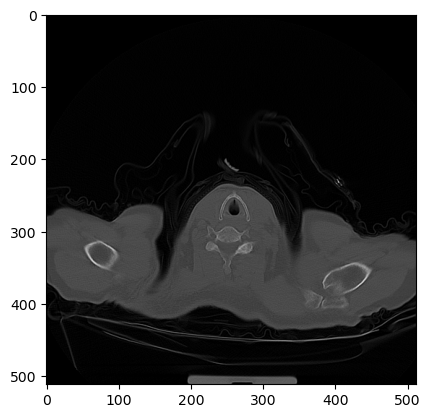

In [58]:
image_dir = os.path.join('../../data/sampled', 'Final_Images')
example_image = os.path.join('../../data/sampled/Final_Images/Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-Chest-07990/2.000000-5mm-40805', '1-01.dcm')
image = read_dicom_image(example_image)
plt.imshow(image, cmap='gray')
plt.show()

## Preprocessing (patient data)

### Demographic Data

In [59]:
df_final = df[df['NewPatientID'].isin(patient_ids)]

In [60]:
df_final.shape

(157, 10)

In [61]:
df_final.describe()

,Age,weight (kg),N-Stage,Smoking History
count,157.000000,155.000000,157.000000,157.000000
mean,60.076433,65.046452,1.280255,0.477707
std,10.182653,11.675917,1.270142,0.501101
min,28.000000,35.500000,0.000000,0.000000
25%,54.000000,57.000000,0.000000,0.000000
50%,61.000000,65.000000,1.000000,0.000000
75%,67.000000,71.000000,3.000000,1.000000
max,83.000000,98.000000,3.000000,1.000000


In [62]:
df_final.describe(include='object')

,NewPatientID,Sex,T-Stage,Ｍ-Stage,Histopathological grading,Histopathological Diagnosis
count,157,157,157,157,157,157
unique,157,2,10,5,6,4
top,A0001,M,1c,0,no grading,A
freq,1,91,34,88,75,77


In [63]:
total_observations = len(df_final)
nan_info_list = []

for column in df_final.columns:
    nan_count = df_final[column].isna().sum()
    nan_percentage = (nan_count / total_observations) * 100
    nan_info_list.append({'Column Name': column,
                          'NaN Count': nan_count,
                          'Percentage of NaNs': f"{nan_percentage:.2f}%",
                          'Total Observations': total_observations})

nan_info = pd.DataFrame(nan_info_list)

display(nan_info)

,Column Name,NaN Count,Percentage of NaNs,Total Observations
0,NewPatientID,0,0.00%,157
1,Sex,0,0.00%,157
2,Age,0,0.00%,157
3,weight (kg),2,1.27%,157
4,T-Stage,0,0.00%,157
5,N-Stage,0,0.00%,157
6,Ｍ-Stage,0,0.00%,157
7,Histopathological grading,0,0.00%,157
8,Smoking History,0,0.00%,157
9,Histopathological Diagnosis,0,0.00%,157


In [64]:
df_final['Histopathological Diagnosis'].value_counts()

Histopathological Diagnosis
A    77
G    38
B    37
E     5
Name: count, dtype: int64

In [65]:
df_final[df_final['Histopathological Diagnosis']== 'B']

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History,Histopathological Diagnosis
No.,,,,,,,,,,
252,B0001,F,66.0,52.0,2,3,0,G3,0,B
253,B0002,F,73.0,72.5,3,3,1b,G3,0,B
254,B0003,M,65.0,67.0,1c,3,0,G3,0,B
255,B0004,M,77.0,70.0,3,3,1b,G3,1,B
256,B0005,F,58.0,88.0,4,3,0,G3,1,B
257,B0006,F,65.0,56.0,1c,3,0,G3,0,B
258,B0007,M,55.0,66.0,1c,3,0,G3,0,B
259,B0008,F,62.0,52.0,3,0,0,G3,0,B
260,B0009,F,40.0,53.0,1c,3,0,G3,1,B


In [66]:
df_final['Histopathological grading'].value_counts()

Histopathological grading
no grading    75
G3            55
G2-G3         10
G2             9
G1             5
G1-G2          3
Name: count, dtype: int64

In [67]:
df_final['T-Stage'].value_counts()

T-Stage
1c    34
3     31
2     29
2a    21
4     15
1b    14
1a     6
2b     5
is     1
1      1
Name: count, dtype: int64

In [68]:
df_final['N-Stage'].value_counts()

N-Stage
0    60
3    50
1    43
2     4
Name: count, dtype: int64

In [69]:
df_final['Ｍ-Stage'].value_counts()

Ｍ-Stage
0     88
1a    21
1b    19
1     19
1c    10
Name: count, dtype: int64